In [125]:
import pandas as pd
import numpy as np
import dgl
from scipy.spatial import distance_matrix
import torch
import pickle

In [126]:
# 预处理
# 将场次小于5的球员删除，选择最近五年球队球员数据,归一化
data = pd.read_csv('./player_dataall.csv')
data = data[data['场次'] > 5]
norm = data.loc[:,['出场时间','投篮命中率','三分命中率','罚球命中率','进攻篮板','防守篮板','篮板','助攻','抢断','盖帽','失误','犯规','得分']]
df_norm = (norm - norm.min()) / (norm.max() - norm.min())
data = data.loc[:,['球员','赛季','所在球队']]
data = pd.concat([data,df_norm],axis=1)

In [127]:
qiudui = data['所在球队'].drop_duplicates().drop([33,117,950])
saiji_train = sorted(data['赛季'].drop_duplicates())[-5:-1]
saiji_test = sorted(data['赛季'].drop_duplicates())[-1]
tmp = pd.DataFrame()
for j in qiudui:
    for i in saiji:
        try:
            a = data[data['赛季']==i].groupby(by=['所在球队']).groups[j]
            a = a.tolist()
            b = pd.DataFrame(data[data['赛季']==i].loc[a,:])
            tmp = pd.concat([b,tmp])
        except:
            continue
tmp.to_csv('./球队各赛季人员数据归一.csv', index=False)

In [128]:
team_rank = pd.read_excel('./team_rank.xlsx')
team_rank = team_rank.replace({'热火': 'Heat','凯尔特人':'Celtics','雄鹿':'Bucks','76人':'76ers','猛龙':'Raptors',
                   '公牛':'Bulls','篮网': 'Nets','老鹰':'Hawks','骑士':'Cavaliers','黄蜂':'Hornets',
                   '尼克斯':'Knicks', '奇才':'Wizards','步行者':'Pacers','活塞': 'Pistons','魔术':'Magic',
                   '太阳':'Suns','灰熊':'Grizzlies','勇士':'Warriors','独行侠': 'Mavericks','爵士':'Jazz',
                   '掘金':'Nuggets','森林狼':'Timberwolves','鹈鹕': 'Pelicans','快船':'Clippers',
                   '马刺': 'Spurs','湖人':'Lakers','国王': 'Kings','开拓者':'Trail Blazers',
                   '雷霆': 'Thunder','火箭':'Rockets'})
opo = team_rank[team_rank.赛季 == i].loc[:,['排名','球队']]
paiming = opo[opo.球队  == j]['排名'].tolist()
# print(paiming)
# paiming = pd.DataFrame(np.array(paiming))

# if paiming[0] >= 1 and paiming[0] <= 3:
#     paiming.replace({paiming[0]: 0})
# elif paiming[0] >= 4 and paiming[0] <= 6:
#     paiming.replace({paiming[0]: 1})
# elif paiming[0] >= 7 and paiming[0] <= 9:
#     paiming.replace({paiming[0]: 2})
# elif paiming[0] >= 10 and paiming[0] <= 12:
#     paiming.replace({paiming[0]: 3})
# elif paiming[0] >= 13 and paiming[0] <= 15:
#     paiming.replace({paiming[0]: 4})

In [132]:
res_train = []
res_test = []
tha = 0.55
for j in qiudui:
    for i in saiji_train:
            a = data[data['赛季']==i].groupby(by=['所在球队']).groups[j]
            a = a.tolist()
            b = pd.DataFrame(data[data['赛季']==i].loc[a,:])
            df = b.set_index(['球员'])
            df = df.loc[:,['出场时间','投篮命中率','三分命中率','罚球命中率','进攻篮板','防守篮板','篮板','助攻','抢断','盖帽','失误','犯规','得分']]
            dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index,columns=df.index)
            pos = np.where(dist_matrix<=tha)
            x, y = pos
            feat_data = torch.Tensor(df.values)
            g = dgl.DGLGraph()
            g.add_edges(x,y)
            g.ndata['feat']= feat_data
            opo = team_rank[team_rank.赛季 == i].loc[:,['排名','球队']]
            paiming = opo[opo.球队  == j]['排名'].tolist()
            if paiming[0] >= 1 and paiming[0] <= 3:
                paiming[0] = 0
            elif paiming[0] >= 4 and paiming[0] <= 6:
                paiming[0] = 1
            elif paiming[0] >= 7 and paiming[0] <= 9:
                paiming[0] = 2
            elif paiming[0] >= 10 and paiming[0] <= 12:
                paiming[0] = 3
            elif paiming[0] >= 13 and paiming[0] <= 15:
                paiming[0] = 4
            paiming = torch.Tensor(paiming)
            paiming = paiming.expand(g.num_nodes(),1)
            g.ndata['y'] = paiming
            res_train.append(g)
for j in qiudui:
    a = data[data['赛季']=='2021-22'].groupby(by=['所在球队']).groups[j]
    a = a.tolist()
    b = pd.DataFrame(data[data['赛季']=='2021-22'].loc[a,:])
    df = b.set_index(['球员'])
    df = df.loc[:,['出场时间','投篮命中率','三分命中率','罚球命中率','进攻篮板','防守篮板','篮板','助攻','抢断','盖帽','失误','犯规','得分']]
    dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index,columns=df.index)
    pos = np.where(dist_matrix<=tha)
    x, y = pos
    feat_data = torch.Tensor(df.values)
    g = dgl.DGLGraph()
    g.add_edges(x,y)
    g.ndata['feat']= feat_data
    opo = team_rank[team_rank.赛季 == '2021-22'].loc[:,['排名','球队']]
    paiming = opo[opo.球队  == j]['排名'].tolist()
    if paiming[0] >= 1 and paiming[0] <= 3:
        paiming[0] = 0
    elif paiming[0] >= 4 and paiming[0] <= 6:
        paiming[0] = 1
    elif paiming[0] >= 7 and paiming[0] <= 9:
        paiming[0] = 2
    elif paiming[0] >= 10 and paiming[0] <= 12:
        paiming[0] = 3
    elif paiming[0] >= 13 and paiming[0] <= 15:
        paiming[0] = 4
    paiming = torch.Tensor(paiming)
    paiming = paiming.expand(g.num_nodes(),1)
    g.ndata['y'] = paiming
    res_test.append(g)

D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category,

D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category,

D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category,

D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
D:\anaconda\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


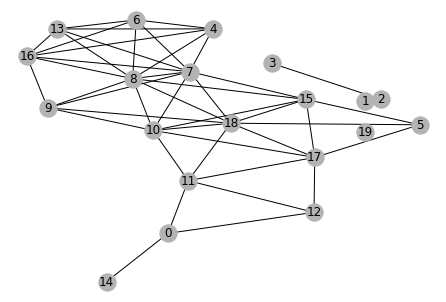

In [133]:
import networkx as nx
# 由于实际图形是无向的，因此我们去掉边的方向，以达到可视化的目的
nx_G = g.to_networkx().to_undirected()
# 为了图更加美观，我们使用Kamada-Kawaii layout 
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [134]:
with open('./train_data.pkl', 'wb') as f:
    pickle.dump(res_train, f)
with open('./test_data.pkl', 'wb') as f1:
    pickle.dump(res_test, f1)    